In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import numpy as np
import gensim.downloader as api
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from datasets import load_dataset
from sklearn.preprocessing import MultiLabelBinarizer

# Loading the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data, val_data, test_data = dataset["train"], dataset["validation"], dataset["test"]

# Function for data preparation
def prepare_data(data):
    texts = [' '.join(tokens) for tokens in data['tokens']]
    return texts, data['ner_tags']

# Preparing the data
X_train, y_train = prepare_data(train_data)
X_val, y_val = prepare_data(val_data)
X_test, y_test = prepare_data(test_data)

# Function to binarize labels
def binarize_labels(labels):
    mlb = MultiLabelBinarizer()
    return mlb.fit_transform([set(tags) for tags in labels]), mlb

# Binarize training, validation, and test labels
y_train_encoded, mlb = binarize_labels(y_train)
y_val_encoded = mlb.transform([set(tags) for tags in y_val])
y_test_encoded = mlb.transform([set(tags) for tags in y_test])

# Training WordPiece tokenizer
tokenizer = Tokenizer(models.WordPiece())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
concatenated_texts = X_train + X_val + X_test
trainer = trainers.WordPieceTrainer(vocab_size=10000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
tokenizer.train_from_iterator(concatenated_texts, trainer=trainer)

# Encoding the text data
X_train_enc = [tokenizer.encode(text).ids for text in X_train]
X_val_enc = [tokenizer.encode(text).ids for text in X_val]
X_test_enc = [tokenizer.encode(text).ids for text in X_test]

# Padding sequences
max_length = max(len(ids) for ids in X_train_enc + X_val_enc + X_test_enc)
X_train_pad = pad_sequences(X_train_enc, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_enc, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_enc, maxlen=max_length, padding='post')

# Loading FastText model
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

# Initializing embedding matrix
embedding_matrix_fasttext = np.zeros((len(tokenizer.get_vocab()) + 1, 300))
for word, idx in tokenizer.get_vocab().items():
    embedding_matrix_fasttext[idx] = fasttext_model.get_vector(word) if word in fasttext_model else np.zeros(300)

# Building the FNN model
model_fnn_fasttext = Sequential([
    Embedding(input_dim=len(tokenizer.get_vocab()) + 1, output_dim=300, weights=[embedding_matrix_fasttext], input_length=max_length, trainable=False),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='sigmoid')  
])

# Compiling the model
model_fnn_fasttext.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
model_fnn_fasttext.fit(X_train_pad, y_train_encoded, epochs=10, validation_data=(X_val_pad, y_val_encoded), batch_size=32)

# Prediction on test data
y_pred_fnn_fasttext = model_fnn_fasttext.predict(X_test_pad) > 0.5


Epoch 1/10
34/34 [==============================] - 14s 376ms/step - loss: 0.3339 - accuracy: 0.1026 - val_loss: 0.3003 - val_accuracy: 0.0794
Epoch 2/10
34/34 [==============================] - 14s 405ms/step - loss: 0.1798 - accuracy: 0.1017 - val_loss: 0.2861 - val_accuracy: 0.0794
Epoch 3/10
34/34 [==============================] - 16s 449ms/step - loss: 0.0994 - accuracy: 0.1017 - val_loss: 0.3066 - val_accuracy: 0.0794
Epoch 4/10
34/34 [==============================] - 13s 392ms/step - loss: 0.0558 - accuracy: 0.1054 - val_loss: 0.3414 - val_accuracy: 0.0873
Epoch 5/10
34/34 [==============================] - 14s 403ms/step - loss: 0.0313 - accuracy: 0.1138 - val_loss: 0.3642 - val_accuracy: 0.0873
Epoch 6/10
34/34 [==============================] - 13s 370ms/step - loss: 0.0194 - accuracy: 0.1297 - val_loss: 0.3878 - val_accuracy: 0.1587
Epoch 7/10
34/34 [==============================] - 14s 401ms/step - loss: 0.0128 - accuracy: 0.1474 - val_loss: 0.4044 - val_accuracy: 0.1587

In [19]:
from sklearn.metrics import classification_report

# Generating the classification report using binary label format directly
report = classification_report(y_test_encoded, y_pred_fnn_fasttext, target_names=mlb.classes_, zero_division=0)
print(report)

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)
print("Accuracy:", accuracy)




              precision    recall  f1-score   support

        B-AC       0.91      0.97      0.94       131
        B-LF       0.85      0.96      0.90       113
         B-O       1.00      1.00      1.00       153
        I-LF       0.76      0.93      0.83       100

   micro avg       0.89      0.97      0.93       497
   macro avg       0.88      0.97      0.92       497
weighted avg       0.89      0.97      0.93       497
 samples avg       0.89      0.97      0.90       497

Accuracy: 0.8741830065359477


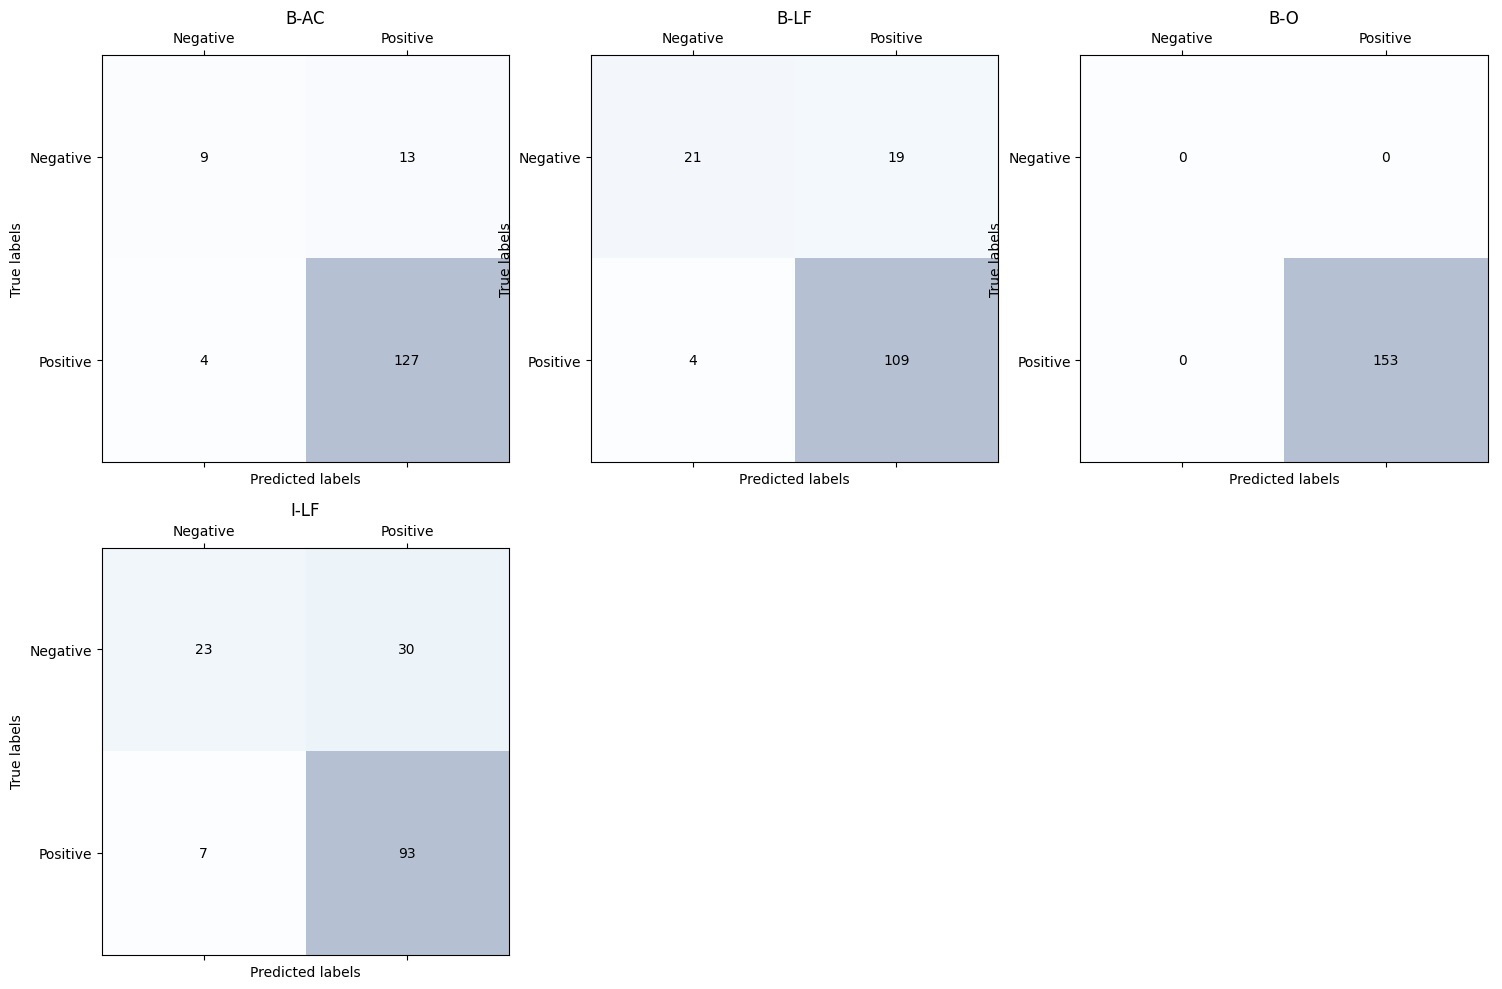

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Generate the multilabel confusion matrix
conf_matrices = multilabel_confusion_matrix(y_test_encoded, y_pred_fnn_fasttext)

# Plotting the confusion matrices
fig, axes = plt.subplots(nrows=int(len(mlb.classes_)/3)+1, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for i, matrix in enumerate(conf_matrices):
    ax = axes[i]
    ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
    for (j, k), val in np.ndenumerate(matrix):
        ax.text(k, j, f"{val}", ha='center', va='center')
    ax.set_title(mlb.classes_[i])
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticks([0,1])
    ax.set_yticklabels(['Negative', 'Positive'])

for ax in axes[len(mlb.classes_):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
